In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import Counter as counter
import json
from math import log
from tabulate import tabulate
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Creating lists of lists for the movies and users and mapping the Ids to indices. I also split the data here to prepare for training.

In [12]:
#Reading, Indexing and splitting the data


ratings = pd.read_csv('/content/drive/MyDrive/ml-25m/ratings.csv')

# Initialize user and movie mappings
user_to_idx = {}
movie_to_idx = {}
id_to_user = []
id_to_movie = []

for row in ratings.itertuples():
    user_id = row.userId
    movie_id = row.movieId

    # Map user_id to an index
    if user_id not in user_to_idx:
        user_idx = len(user_to_idx)
        user_to_idx[user_id] = user_idx
        id_to_user.append(user_id)

    # Map movie_id to an index
    if movie_id not in movie_to_idx:
        movie_idx = len(movie_to_idx)
        movie_to_idx[movie_id] = movie_idx
        id_to_movie.append(movie_id)

# Initialize empty lists for users and movies
ratings_by_users = [[] for _ in range(len(user_to_idx))]
ratings_by_movies = [[] for _ in range(len(movie_to_idx))]

# Append ratings to lists
for row in ratings.itertuples():
    user = row.userId
    movie = row.movieId
    rating = row.rating

    user_idx = user_to_idx[user]
    movie_idx = movie_to_idx[movie]

    ratings_by_users[user_idx].append((movie_idx, rating))
    ratings_by_movies[movie_idx].append((user_idx, rating))

# Initialize training and testing sets
ratings_by_users_train = [[] for _ in range(len(ratings_by_users))]
ratings_by_users_test = [[] for _ in range(len(ratings_by_users))]

ratings_by_movies_train = [[] for _ in range(len(ratings_by_movies))]
ratings_by_movies_test = [[] for _ in range(len(ratings_by_movies))]

# Split the data into training and testing sets (80/20 split)
for user_idx, user_ratings in enumerate(ratings_by_users):
    np.random.shuffle(user_ratings)
    split_idx = int(len(user_ratings) * 0.8)

    # Split ratings_by_users for training and testing
    ratings_by_users_train[user_idx] = user_ratings[:split_idx]
    ratings_by_users_test[user_idx] = user_ratings[split_idx:]

# Similarly, split the ratings by movies if needed
for movie_idx, movie_ratings in enumerate(ratings_by_movies):
    np.random.shuffle(movie_ratings)
    split_idx = int(len(movie_ratings) * 0.8)

    # Split ratings_by_movies for training and testing
    ratings_by_movies_train[movie_idx] = movie_ratings[:split_idx]
    ratings_by_movies_test[movie_idx] = movie_ratings[split_idx:]




In [ ]:

# Save mappings to Drive
mappings_dir = '/content/drive/MyDrive/mappings/'

# Save user_to_idx and movie_to_idx as JSON files
with open(f'{mappings_dir}user_to_idx.json', 'w') as f:
    json.dump(user_to_idx, f)

with open(f'{mappings_dir}movie_to_idx.json', 'w') as f:
    json.dump(movie_to_idx, f)

# Save id_to_user and id_to_movie as CSV files
pd.DataFrame({'userId': id_to_user}).to_csv(f'{mappings_dir}id_to_user.csv', index_label="User_Index")
pd.DataFrame({'movieId': id_to_movie}).to_csv(f'{mappings_dir}id_to_movie.csv', index_label="Movie_Index")

print("Mappings saved successfully to Google Drive.")


In [ ]:
# Check the number of users and movies in the train and test sets
train_users_size = len(ratings_by_users_train)
test_users_size = len(ratings_by_users_test)

train_movies_size = len(ratings_by_movies_train)
test_movies_size = len(ratings_by_movies_test)

print(f"Train set size (users): {train_users_size}, Test set size (users): {test_users_size}")
print(f"Train set size (movies): {train_movies_size}, Test set size (movies): {test_movies_size}")

Train set size (users): 162541, Test set size (users): 162541
Train set size (movies): 59047, Test set size (movies): 59047


In [ ]:
# Check train-test split sizes for users and movies
train_user_size = sum([len(x) for x in ratings_by_users_train])
test_user_size = sum([len(x) for x in ratings_by_users_test])
train_movie_size = sum([len(x) for x in ratings_by_movies_train])
test_movie_size = sum([len(x) for x in ratings_by_movies_test])

print(f"Train size (users): {train_user_size}, Test size (users): {test_user_size}")
print(f"Train size (movies): {train_movie_size}, Test size (movies): {test_movie_size}")

Train size (users): 19936012, Test size (users): 5064083
Train size (movies): 19971697, Test size (movies): 5028398




Plotted the data distribution and used counters to find the frequency and count for the users and movies plotting it to show that it follows the powr law.

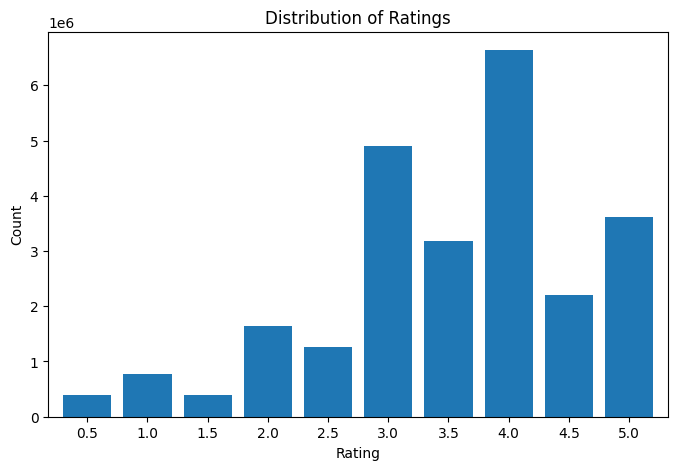

In [3]:
plt.figure(figsize=(8, 5))
ratings['rating'].value_counts().sort_index().plot(kind='bar', width=0.8)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.savefig('rating_distribution.pdf', format = 'pdf' )
plt.show()

In [ ]:

# counter to calculate thde degrees for both users & movies
user_rep = counter()
movie_rep = counter()

for row in ratings.itertuples():
    user = row.userId
    user_rep[user_to_idx[user]] += 1

    movie = row.movieId
    movie_rep[movie_to_idx[movie]] += 1


# counter to calculate thde frequencies for both users & movies
user_freq = counter(user_rep.values())

movie_freq = counter(movie_rep.values())




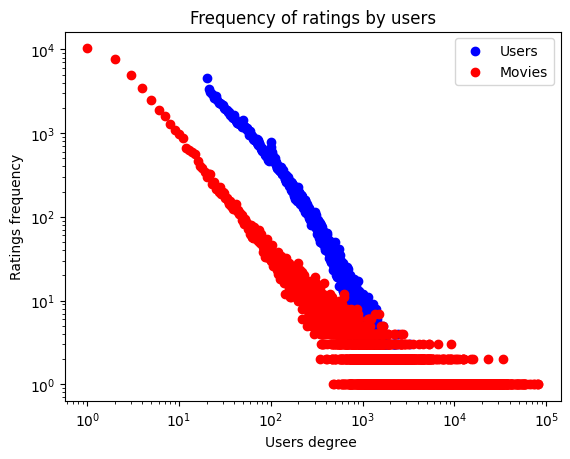

In [ ]:
# Plotting the data distribution

user_degree = list(user_freq.keys())
ratings_by_user = list(user_freq.values())
movies_degree = list(movie_freq.keys())
ratings_by_movie = list(movie_freq.values())


plt.scatter(user_degree, ratings_by_user,marker='o', color='blue', label='Users')
plt.scatter(movies_degree, ratings_by_movie,marker='o', color='red', label='Movies')

plt.xscale('log')
plt.yscale('log')
plt.title('Frequency of ratings by users')
plt.xlabel('Users degree ')
plt.ylabel('Ratings frequency')
plt.legend()
plt.savefig('Data_Distrubtion_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()




ALS Model with Biases only

In [ ]:

# Set regularization parameters and iteration count
lambda_ = 0.1
gamma = 0.1
iterations = 10
# Initialize user and movie biases as zeros
movie_biases = np.zeros(len(ratings_by_movies_train))
user_biases = np.zeros(len(ratings_by_users_train))

# Store losses and RMSEs
train_losses = []
test_losses = []
Train_rmse = []
Test_rmse = []

# Function to calculate NLL
def Calculate_Loss(ratings_train, user_biases, movie_biases, lambda_, gamma):
    log_likelihood_loss = 0

    # Squared error term
    for user_id, user_rating in enumerate(ratings_train):
        for movie_id, rating in user_rating:
            predicted = user_biases[user_id] + movie_biases[movie_id]
            error = rating - predicted
            log_likelihood_loss += (error) ** 2

    # Regularization term for user and movie biases
    user_bias_regularization = 0.5 * gamma * (user_biases ** 2).sum()
    movie_bias_regularization = 0.5 * gamma * (movie_biases ** 2).sum()

   # Total loss
    log_likelihood_loss += user_bias_regularization + movie_bias_regularization

    return log_likelihood_loss

# RMSE Function
def compute_rmse(ratings_train, user_biases, movie_biases):
    total_error = 0
    count = 0

    for user_id, user_rating in enumerate(ratings_train):
        for movie_id, rating in user_rating:
            prediction = user_biases[user_id] + movie_biases[movie_id]
            error = rating - prediction
            total_error += error ** 2
            count += 1

    rmse = np.sqrt(total_error / count) if count > 0 else 0
    return rmse

# ALS iterations for biases only
for i in range(iterations):
    print(f"Iteration {i+1} starts...")

    # Update user biases
    for m in range(len(ratings_by_users_train)):
        bias_sum = 0
        item_counter = 0
        for movie, rating in ratings_by_users_train[m]:
            if rating != 0:
                bias_sum += rating - movie_biases[movie]
                item_counter += 1
        if item_counter > 0:
            user_biases[m] = bias_sum / (item_counter + lambda_)

    # Update movie biases
    for n in range(len(ratings_by_movies_train)):
        bias_sum = 0
        item_counter = 0
        for user, rating in ratings_by_movies_train[n]:
            if rating != 0:
                bias_sum += rating - user_biases[user]
                item_counter += 1
        if item_counter > 0:
            movie_biases[n] = bias_sum / (item_counter + lambda_)

    # Calculate the loss and RMSE
    train_loss = Calculate_Loss(ratings_by_users_train, user_biases, movie_biases, lambda_, gamma)
    test_loss = Calculate_Loss(ratings_by_users_test, user_biases, movie_biases, lambda_, gamma)

    train_rmse = compute_rmse(ratings_by_users_train, user_biases, movie_biases)
    test_rmse = compute_rmse(ratings_by_users_test, user_biases, movie_biases)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    Train_rmse.append(train_rmse)
    Test_rmse.append(test_rmse)

    print(f"Iteration {i+1}: Train RMSE = {train_rmse}, Test RMSE = {test_rmse}")
    print(f"Iteration {i+1} ends...\n")

# Save RMSE values and losses to Drive
results = pd.DataFrame({
    "Iteration": range(1, iterations + 1),
    "Train_RMSE": Train_rmse,
    "Test_RMSE": Test_rmse,
    "Train_Loss": train_losses,
    "Test_Loss": test_losses
})
results.to_csv('/content/drive/MyDrive/ALS_bias_results.csv', index=False)

# Save user and movie biases to Drive
user_biases_df = pd.DataFrame(user_biases, columns=["User_Bias"])
user_biases_df.to_csv('/content/drive/MyDrive/User_Biases.csv', index_label="User_ID")

movie_biases_df = pd.DataFrame(movie_biases, columns=["Movie_Bias"])
movie_biases_df.to_csv('/content/drive/MyDrive/Movie_Biases.csv', index_label="Movie_ID")


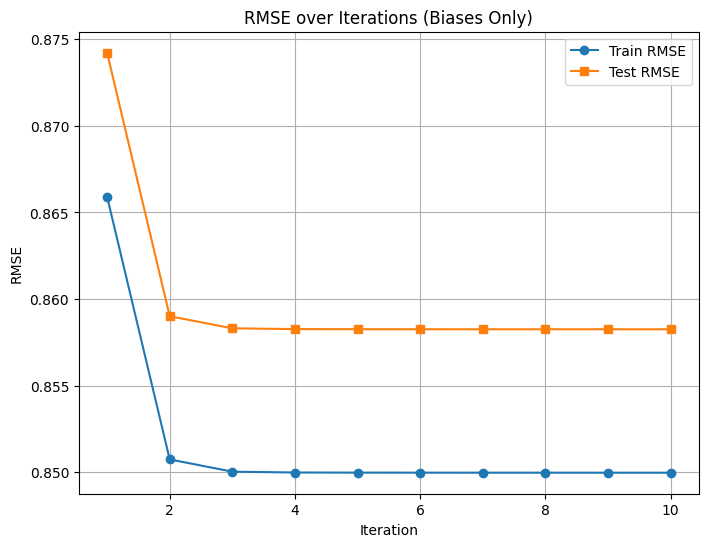

In [ ]:

# Plot the RMSE for training and test sets over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(Train_rmse)+1), Train_rmse, label="Train RMSE", marker='o')
plt.plot(range(1, len(Test_rmse)+1), Test_rmse, label="Test RMSE", marker='s')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE over Iterations (Biases Only)')
plt.legend()
plt.grid(True)

plt.savefig('Bias_only_rmse_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


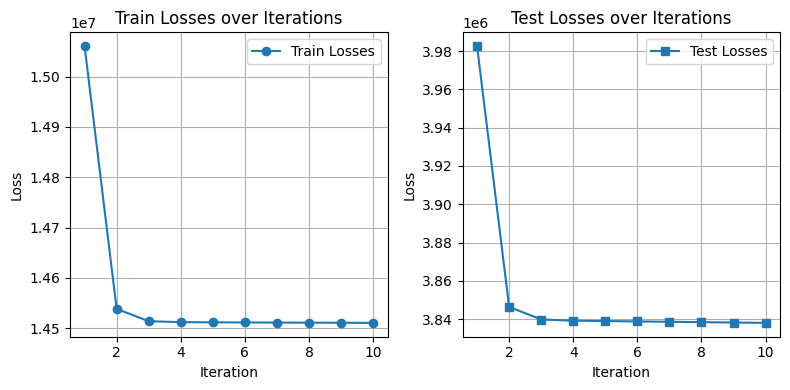

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot for train losses
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="Train Losses", marker='o')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train Losses over Iterations')
axs[0].legend()
axs[0].grid(True)

# Plot for test losses
axs[1].plot(range(1, len(test_losses) + 1), test_losses, label="Test Losses", marker='s')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')
axs[1].set_title('Test Losses over Iterations')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.savefig('Bias Only Loss_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()



ALS Model with Biases and Latent Factors

In [ ]:
#Training with 4 different hyperparameters configuration sets

train1 = pd.read_csv('/content/drive/MyDrive/1_1M_ALS_bias_vector_results.csv')
train2 = pd.read_csv('/content/drive/MyDrive/2_1M_ALS_bias_vector_results.csv')
train3 = pd.read_csv('/content/drive/MyDrive/3_1M_ALS_bias_vector_results.csv')
train4 = pd.read_csv('/content/drive/MyDrive/4_1M_ALS_bias_vector_results.csv')

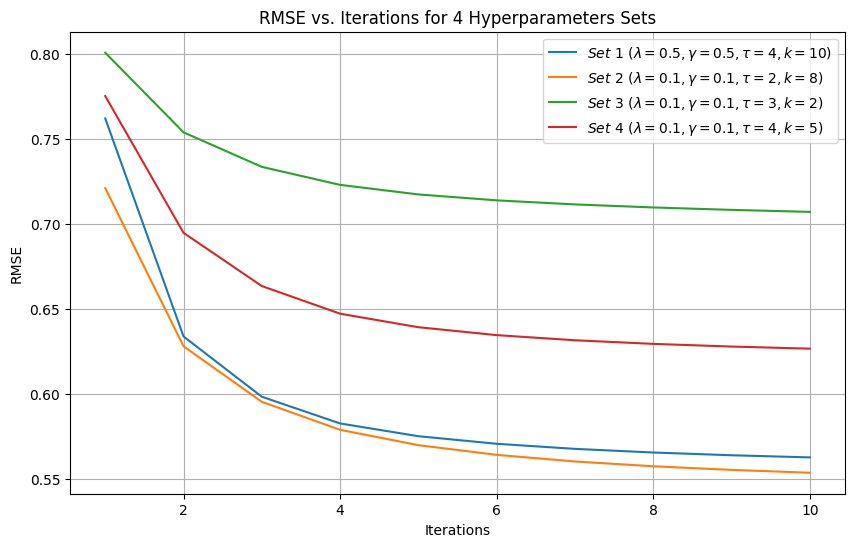

In [ ]:
#RMSE over iterations for the 4 hyperparameter sets

plt.figure(figsize=(10, 6))
plt.plot(train1['Iteration'], train1['Train_RMSE'], label= r"$Set\ 1\ (\lambda = 0.5, \gamma = 0.5, \tau= 4, k = 10$)")
plt.plot(train2['Iteration'], train2['Train_RMSE'], label= r"$Set\ 2\ (\lambda = 0.1, \gamma = 0.1, \tau = 2, k = 8$)")
plt.plot(train3['Iteration'], train3['Train_RMSE'], label= r"$Set\ 3\ (\lambda = 0.1, \gamma = 0.1, \tau = 3, k = 2$)")
plt.plot(train4['Iteration'], train4['Train_RMSE'], label= r"$Set\ 4\ (\lambda = 0.1, \gamma = 0.1, \tau = 4, k = 5$)")

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE vs. Iterations for 4 Hyperparameters Sets')
plt.legend()
plt.savefig('/content/Hyperparameters_tuning.pdf', format='pdf')
plt.grid(True)
plt.show()

In [ ]:
#Regularization Parameters
lambda_ = 0.5
gamma = 0.5
tau = 4
iterations = 15
k = 10

#  user and movie biases initialization
movie_biases = np.zeros(len(ratings_by_movies))
user_biases = np.zeros(len(ratings_by_users))

#  user and movie vectors initialization
user_vectors = np.random.uniform(0, 1 / np.sqrt(k), (len(ratings_by_users), k))
movie_vectors = np.random.uniform(0, 1 / np.sqrt(k), (len(ratings_by_movies), k))


train_losses = []
test_losses = []
Train_rmse = []
Test_rmse = []

#  loss with regularization for biases and latent factors
def Calculate_Loss(ratings_users, user_biases, movie_biases, user_vectors, movie_vectors, lambda_, gamma, tau):
    log_likelihood_loss = 0

    # Squared error
    for user_id, user_rating in enumerate(ratings_users):
        for movie_id, rating in user_rating:
            predicted = np.dot(user_vectors[user_id], movie_vectors[movie_id]) + user_biases[user_id] + movie_biases[movie_id]
            error = rating - predicted
            log_likelihood_loss += (error) ** 2


    user_bias_regularization = 0.5 * gamma * (user_biases ** 2).sum()
    movie_bias_regularization = 0.5 * gamma * (movie_biases ** 2).sum()

    user_vector_regularization = 0.5 * lambda_ * (user_vectors ** 2).sum()
    movie_vector_regularization = 0.5 * lambda_ * (movie_vectors ** 2).sum()

    log_likelihood_loss += user_bias_regularization + movie_bias_regularization
    log_likelihood_loss += user_vector_regularization + movie_vector_regularization

    return log_likelihood_loss

#  RMSE
def compute_rmse(ratings_users, user_biases, movie_biases, user_vectors, movie_vectors):
    total_error = 0
    count = 0

    for user_id, user_rating in enumerate(ratings_users):
        for movie_id, rating in user_rating:
            prediction = np.dot(user_vectors[user_id], movie_vectors[movie_id]) + user_biases[user_id] + movie_biases[movie_id]
            error = rating - prediction
            total_error += error ** 2
            count += 1

    rmse = np.sqrt(total_error / count) if count > 0 else 0
    return rmse


# ALS iterations with biases and latent factors
for i in range(iterations):
    print(f"\nIteration {i+1} starts...")



    #  update user biases
    for m in range(len(ratings_by_users)):
        bias_sum = 0
        item_counter = 0
        for movie, rating in ratings_by_users[m]:
            if rating != 0:
                bias_sum += rating - movie_biases[movie] - np.dot(user_vectors[m], movie_vectors[movie])
                item_counter += 1
        if item_counter > 0:
            user_biases[m] = bias_sum / (item_counter + lambda_)



        # update user latent factors
    for m in range(len(ratings_by_users)):
        rated_movies = [entry for entry in ratings_by_users[m] if entry[1] != 0]  # List of movies rated by user m
        if rated_movies:
            V_T_V = np.dot(movie_vectors[[movie for movie, _ in rated_movies]].T,
                          movie_vectors[[movie for movie, _ in rated_movies]]) + tau * np.eye(k)
            right_term = np.dot(movie_vectors[[movie for movie, _ in rated_movies]].T,
                                [rating - movie_biases[movie] - user_biases[m] for movie, rating in rated_movies])
            user_vectors[m] = np.linalg.solve(V_T_V + lambda_ * np.eye(k), right_term)



    #  update movie biases
    for n in range(len(ratings_by_movies)):
        bias_sum = 0
        item_counter = 0
        for user, rating in ratings_by_movies[n]:
            if rating != 0:
                bias_sum += rating - user_biases[user] - np.dot(user_vectors[user], movie_vectors[n])
                item_counter += 1
        if item_counter > 0:
            movie_biases[n] = bias_sum / (item_counter + lambda_)



      # Update movie latent factors
    for n in range(len(ratings_by_movies)):
        rated_users = [entry for entry in ratings_by_movies[n] if entry[1] != 0]  # List of users who rated movie n
        if rated_users:
            U_T_U = np.dot(user_vectors[[user for user, _ in rated_users]].T,
                          user_vectors[[user for user, _ in rated_users]]) + tau * np.eye(k)
            right_term = np.dot(user_vectors[[user for user, _ in rated_users]].T,
                                [rating - user_biases[user] - movie_biases[n] for user, rating in rated_users])
            movie_vectors[n] = np.linalg.solve(U_T_U + lambda_ * np.eye(k), right_term)


    # Calculate the loss
    train_loss = Calculate_Loss(ratings_by_users, user_biases, movie_biases, user_vectors, movie_vectors, lambda_, gamma, tau)
    test_loss = Calculate_Loss(ratings_by_users_test, user_biases, movie_biases, user_vectors, movie_vectors, lambda_, gamma, tau)

    # Calculate the loss
    train_rmse = compute_rmse(ratings_by_users, user_biases, movie_biases, user_vectors, movie_vectors)
    test_rmse = compute_rmse(ratings_by_users_test, user_biases, movie_biases, user_vectors, movie_vectors)


    train_losses.append(train_loss)
    test_losses.append(test_loss)
    Train_rmse.append(train_rmse)
    Test_rmse.append(test_rmse)



    print(f"Iteration {i+1}: Train RMSE = {train_rmse}, Test RMSE = {test_rmse}")
    print(f"Iteration {i+1} ends...\n")

#Save the results
results = pd.DataFrame({
    "Iteration": range(1, iterations + 1),
    "Train_RMSE": Train_rmse,
    "Test_RMSE": Test_rmse,
    "Train_Loss": train_losses,
    "Test_Loss": test_losses
})
results.to_csv('/content/drive/MyDrive/ALS_bias_vector_results.csv', index=False)


pd.DataFrame(user_biases, columns=["User_Bias"]).to_csv('/content/drive/MyDrive/User_Biases.csv', index_label="User_ID")
pd.DataFrame(movie_biases, columns=["Movie_Bias"]).to_csv('/content/drive/MyDrive/Movie_Biases.csv', index_label="Movie_ID")
pd.DataFrame(user_vectors, columns=[f"Latent_{i}" for i in range(k)]).to_csv('/content/drive/MyDrive/User_Vectors.csv', index_label="User_ID")
pd.DataFrame(movie_vectors, columns=[f"Latent_{i}" for i in range(k)]).to_csv('/content/drive/MyDrive/Movie_Vectors.csv', index_label="Movie_ID")


In [ ]:
Train_rmse = pd.read_csv('/content/drive/MyDrive/ALS_bias_vector_results.csv')['Train_RMSE']
Test_rmse = pd.read_csv('/content/drive/MyDrive/ALS_bias_vector_results.csv')['Test_RMSE']

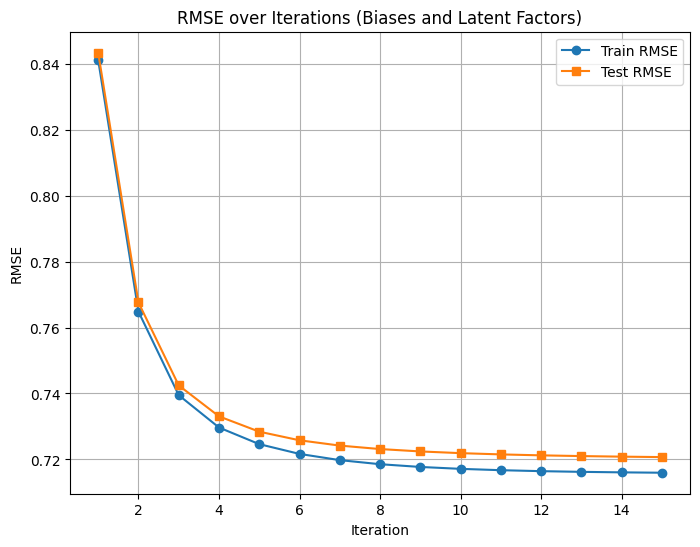

In [ ]:
# Plot RMSE for training and test sets
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(Train_rmse) + 1), Train_rmse, label="Train RMSE", marker='o')
plt.plot(range(1, len(Test_rmse) + 1), Test_rmse, label="Test RMSE", marker='s')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE over Iterations (Biases and Latent Factors)')
plt.legend()
plt.grid(True)


plt.savefig('ALS_RMSE_Plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
Train_loss = pd.read_csv('/content/drive/MyDrive/ALS_bias_vector_results.csv')['Train_Loss']
Test_loss = pd.read_csv('/content/drive/MyDrive/ALS_bias_vector_results.csv')['Test_Loss']

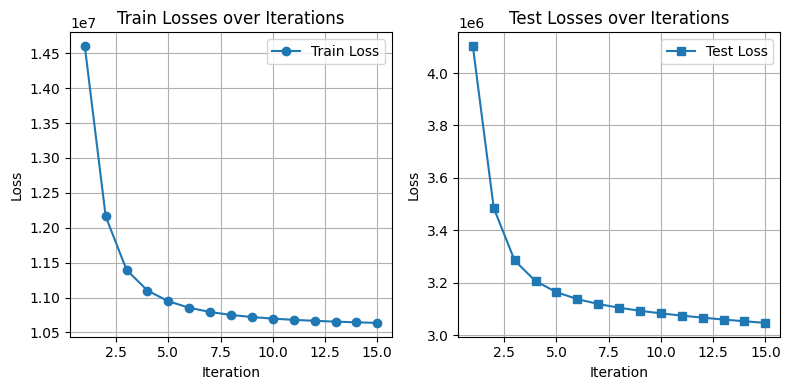

In [ ]:
# Plot Loss for training and test sets
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot for train losses
axs[0].plot(range(1, len(Train_loss) + 1), Train_loss, label="Train Loss", marker='o')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train Losses over Iterations')
axs[0].legend()
axs[0].grid(True)

# Plot for test losses
axs[1].plot(range(1, len(Test_loss) + 1), Test_loss, label="Test Loss", marker='s')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')
axs[1].set_title('Test Losses over Iterations')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.savefig('Bias & latent Loss_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
###### ALS Model with biases and latent factors trained on the full 25M dataset

lambda_ = 0.5
gamma = 0.5
tau = 4
iterations = 15
k = 10

#  user and movie biases initialization
movie_biases = np.zeros(len(ratings_by_movies))
user_biases = np.zeros(len(ratings_by_users))

#  user and movie vectors initialization
user_vectors = np.random.uniform(0, 1 / np.sqrt(k), (len(ratings_by_users), k))
movie_vectors = np.random.uniform(0, 1 / np.sqrt(k), (len(ratings_by_movies), k))


train_losses = []
Train_rmse = []


#  loss with regularization for biases and latent factors
def Calculate_Loss(ratings_users, user_biases, movie_biases, user_vectors, movie_vectors, lambda_, gamma, tau):
    log_likelihood_loss = 0

    # Squared error
    for user_id, user_rating in enumerate(ratings_users):
        for movie_id, rating in user_rating:
            predicted = np.dot(user_vectors[user_id], movie_vectors[movie_id]) + user_biases[user_id] + movie_biases[movie_id]
            error = rating - predicted
            log_likelihood_loss += (error) ** 2


    user_bias_regularization = 0.5 * gamma * (user_biases ** 2).sum()
    movie_bias_regularization = 0.5 * gamma * (movie_biases ** 2).sum()

    user_vector_regularization = 0.5 * lambda_ * (user_vectors ** 2).sum()
    movie_vector_regularization = 0.5 * lambda_ * (movie_vectors ** 2).sum()

    log_likelihood_loss += user_bias_regularization + movie_bias_regularization
    log_likelihood_loss += user_vector_regularization + movie_vector_regularization

    return log_likelihood_loss

#  RMSE
def compute_rmse(ratings_users, user_biases, movie_biases, user_vectors, movie_vectors):
    total_error = 0
    count = 0

    for user_id, user_rating in enumerate(ratings_users):
        for movie_id, rating in user_rating:
            prediction = np.dot(user_vectors[user_id], movie_vectors[movie_id]) + user_biases[user_id] + movie_biases[movie_id]
            error = rating - prediction
            total_error += error ** 2
            count += 1

    rmse = np.sqrt(total_error / count) if count > 0 else 0
    return rmse


# ALS iterations with biases and latent factors
for i in range(iterations):
    print(f"\nIteration {i+1} starts...")



    #  update user biases
    for m in range(len(ratings_by_users)):
        bias_sum = 0
        item_counter = 0
        for movie, rating in ratings_by_users[m]:
            if rating != 0:
                bias_sum += rating - movie_biases[movie] - np.dot(user_vectors[m], movie_vectors[movie])
                item_counter += 1
        if item_counter > 0:
            user_biases[m] = bias_sum / (item_counter + lambda_)



        # update user latent factors
    for m in range(len(ratings_by_users)):
        rated_movies = [entry for entry in ratings_by_users[m] if entry[1] != 0]  # List of movies rated by user m
        if rated_movies:
            V_T_V = np.dot(movie_vectors[[movie for movie, _ in rated_movies]].T,
                          movie_vectors[[movie for movie, _ in rated_movies]]) + tau * np.eye(k)
            right_term = np.dot(movie_vectors[[movie for movie, _ in rated_movies]].T,
                                [rating - movie_biases[movie] - user_biases[m] for movie, rating in rated_movies])
            user_vectors[m] = np.linalg.solve(V_T_V + lambda_ * np.eye(k), right_term)



    #  update movie biases
    for n in range(len(ratings_by_movies)):
        bias_sum = 0
        item_counter = 0
        for user, rating in ratings_by_movies[n]:
            if rating != 0:
                bias_sum += rating - user_biases[user] - np.dot(user_vectors[user], movie_vectors[n])
                item_counter += 1
        if item_counter > 0:
            movie_biases[n] = bias_sum / (item_counter + lambda_)




      # Update movie latent factors
    for n in range(len(ratings_by_movies)):
        rated_users = [entry for entry in ratings_by_movies[n] if entry[1] != 0]  # List of users who rated movie n
        if rated_users:
            U_T_U = np.dot(user_vectors[[user for user, _ in rated_users]].T,
                          user_vectors[[user for user, _ in rated_users]]) + tau * np.eye(k)
            right_term = np.dot(user_vectors[[user for user, _ in rated_users]].T,
                                [rating - user_biases[user] - movie_biases[n] for user, rating in rated_users])
            movie_vectors[n] = np.linalg.solve(U_T_U + lambda_ * np.eye(k), right_term)


    # Calculate the loss
    train_loss = Calculate_Loss(ratings_by_users, user_biases, movie_biases, user_vectors, movie_vectors, lambda_, gamma, tau)


    train_rmse = compute_rmse(ratings_by_users, user_biases, movie_biases, user_vectors, movie_vectors)


    train_losses.append(train_loss)

    Train_rmse.append(train_rmse)



    print(f"Iteration {i+1}: Train RMSE = {train_rmse}")
    print(f"Iteration {i+1} ends...\n")

# Save results
results = pd.DataFrame({
    "Iteration": range(1, iterations + 1),
    "Train_RMSE": Train_rmse,

    "Train_Loss": train_losses,

})
results.to_csv('/content/drive/MyDrive/25M_ALS_bias_vector_results.csv', index=False)


pd.DataFrame(user_biases, columns=["User_Bias"]).to_csv('/content/drive/MyDrive/25M_User_Biases.csv', index_label="User_ID")
pd.DataFrame(movie_biases, columns=["Movie_Bias"]).to_csv('/content/drive/MyDrive/25M_Movie_Biases.csv', index_label="Movie_ID")
pd.DataFrame(user_vectors, columns=[f"Latent_{i}" for i in range(k)]).to_csv('/content/drive/MyDrive/25M_User_Vectors.csv', index_label="User_ID")
pd.DataFrame(movie_vectors, columns=[f"Latent_{i}" for i in range(k)]).to_csv('/content/drive/MyDrive/25M_Movie_Vectors.csv', index_label="Movie_ID")


In [ ]:
Train_rmse = pd.read_csv('/content/drive/MyDrive/25M_ALS_bias_vector_results.csv')['Train_RMSE']
train_losses = pd.read_csv('/content/drive/MyDrive/25M_ALS_bias_vector_results.csv')['Train_Loss']

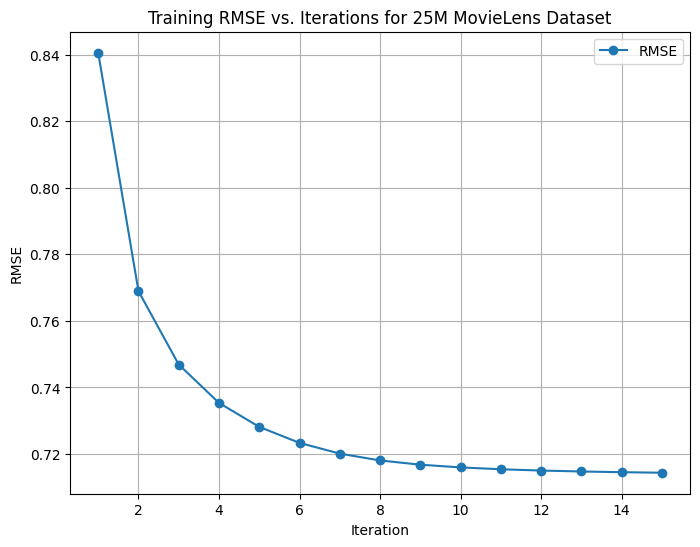

In [ ]:
## Plot RMSE for training on the 25M dataset
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(Train_rmse) + 1), Train_rmse, label="RMSE", marker='o')

plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training RMSE vs. Iterations for 25M MovieLens Dataset')
plt.savefig('/content/25M_ALS_RMSE_Plot.pdf', format='pdf', bbox_inches='tight')
plt.legend()
plt.grid(True)
plt.show()

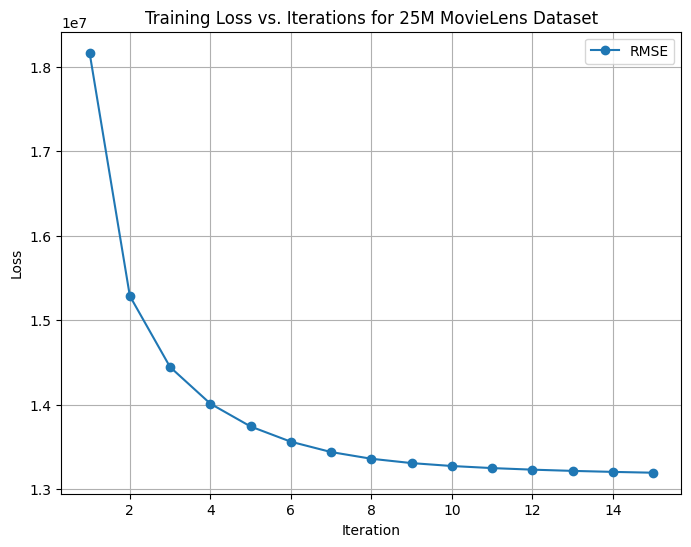

In [ ]:
# Plot Loss for training on the 25M dataset
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="RMSE", marker='o')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss vs. Iterations for 25M MovieLens Dataset')
plt.savefig('/content/25M_ALS_Loss_Plot.pdf', format='pdf', bbox_inches='tight')
plt.legend()
plt.grid(True)
plt.show()



Create a dummy user to test the recommendtion system.

In [ ]:

#25M training
movies = pd.read_csv('/content/drive/MyDrive/ml-25m/movies.csv')
movie_biases = pd.read_csv('/content/drive/MyDrive/25M_Movie_Biases.csv', index_col='Movie_ID')['Movie_Bias'].values
user_biases = pd.read_csv('/content/drive/MyDrive/25M_User_Biases.csv', index_col='User_ID')['User_Bias'].values
movie_vectors = pd.read_csv('/content/drive/MyDrive/25M_Movie_Vectors.csv', index_col='Movie_ID').values
user_vectors = pd.read_csv('/content/drive/MyDrive/25M_User_Vectors.csv', index_col='User_ID').values


# Load the mappings
with open('/content/drive/MyDrive/mappings/user_to_idx.json', 'r') as f:
    user_to_idx = json.load(f)

with open('/content/drive/MyDrive/mappings/movie_to_idx.json', 'r') as f:
    movie_to_idx = json.load(f)

id_to_user = pd.read_csv('/content/drive/MyDrive/mappings/id_to_user.csv', index_col="User_Index")['userId'].tolist()
id_to_movie = pd.read_csv('/content/drive/MyDrive/mappings/id_to_movie.csv', index_col="Movie_Index")['movieId'].tolist()

#Function to Get the Movie Index by Title
def get_movie_index_by_title(title):

    movie_row = movies[movies['title'].str.contains(title, case=False, na=False, regex=False)]
    if movie_row.empty:
        print(f"Movie '{title}' not found.")
        return None
    else:

        movie_id = movie_row.iloc[0]['movieId']
        # Map movie_id to the index used in the ALS model
        if str(movie_id) in movie_to_idx:
            return int(movie_to_idx[str(movie_id)])
        else:
            print(f"Movie ID {movie_id} for '{title}' not found in mapping.")
            return None

# Get the index for the movie to be rate by the dummy user
movie_title = "Lord of the Rings: The Return of the King, The (2003)"
target_movie_index = get_movie_index_by_title(movie_title)
print(f"Index for '{movie_title}':", target_movie_index)

# Create a Dummy User and Get Recommendations
if target_movie_index is not None:
    # Initialize dummy user vector and bias
    dummy_user_vector = np.zeros(k)
    dummy_user_bias = 0.0

    # Dummy user's single rating for the chosen movie
    dummy_user_ratings = [(target_movie_index, 5.0)]

    # Function to update dummy user vector and bias together
    def update_dummy_user_vector_and_bias(dummy_user_vector, dummy_user_bias, dummy_user_ratings, num_updates=5):
        for _ in range(num_updates):  # Run multiple updates for refinement
            # Update the dummy user bias
            bias_sum = 0
            item_counter = len(dummy_user_ratings)

            for movie_index, rating in dummy_user_ratings:
                bias_sum += rating - movie_biases[movie_index] - np.dot(dummy_user_vector, movie_vectors[movie_index])

            if item_counter > 0:
                dummy_user_bias = bias_sum / (item_counter + lambda_)

            # Update the dummy user vector based on the new bias
            for movie_index, rating in dummy_user_ratings:
                V_T_V = np.dot(movie_vectors[movie_index].T, movie_vectors[movie_index]) + tau * np.eye(k)
                right_term = movie_vectors[movie_index] * (rating - movie_biases[movie_index] - dummy_user_bias)
                dummy_user_vector = np.linalg.solve(V_T_V + lambda_ * np.eye(k), right_term)

        return dummy_user_vector, dummy_user_bias


    dummy_user_vector, dummy_user_bias = update_dummy_user_vector_and_bias(
        dummy_user_vector, dummy_user_bias, dummy_user_ratings, num_updates=5
    )

    # Generate recommendations
    def get_recommendations(dummy_user_vector, num_recommendations=10):
        scores = []
        for movie_idx in range(len(movie_vectors)):
            if movie_idx == target_movie_index:
                continue
            score = np.dot(dummy_user_vector, movie_vectors[movie_idx]) + 0.05 * movie_biases[movie_idx]
            scores.append((movie_idx, score))

        # Sort movies by score in descending order and get top recommendations
        top_recommendations = sorted(scores, key=lambda x: x[1], reverse=True)[:num_recommendations]

        # Convert internal indices back to movie titles
        recommendations = [(id_to_movie[movie_idx], score) for movie_idx, score in top_recommendations]
        return recommendations

    # Get recommendations for the dummy user
    recommendations = get_recommendations(dummy_user_vector)


    recommendations_table = pd.DataFrame(
        [
            {'Title': movies[movies['movieId'] == movie_id]['title'].values[0], 'Score': score}
            for movie_id, score in recommendations
        ]
    )

    # Print the table
    print("Top Recommendations for the Dummy User:")

    print(tabulate(recommendations_table, headers='keys', tablefmt='pretty'))


Index for 'Lord of the Rings: The Return of the King, The (2003)': 227
Top Recommendations for the Dummy User:
+---+-----------------------------------------------------------+--------------------+
|   |                           Title                           |       Score        |
+---+-----------------------------------------------------------+--------------------+
| 0 |       Lord of the Rings: The Two Towers, The (2002)       | 770.1606148176286  |
| 1 | Lord of the Rings: The Fellowship of the Ring, The (2001) | 766.8953537667873  |
| 2 |    Star Wars: Episode II - Attack of the Clones (2002)    |  714.678517773577  |
| 3 |    Star Wars: Episode III - Revenge of the Sith (2005)    | 704.2872998426826  |
| 4 |     Star Wars: Episode I - The Phantom Menace (1999)      | 670.9645075469963  |
| 5 |        Hobbit: The Desolation of Smaug, The (2013)        | 600.5577924102954  |
| 6 |         Hobbit: An Unexpected Journey, The (2012)         | 597.3697684027542  |
| 7 |     The Hobbi

Plot the 2D Embeddings for certain movies by training the model with two latent dimensions

In [5]:
movie_vectors = pd.read_csv('/content/drive/MyDrive/2D_Movie_Vectors.csv', index_col='Movie_ID').values
id_to_movie = pd.read_csv('/content/drive/MyDrive/mappings/id_to_movie.csv', index_col="Movie_Index")['movieId'].tolist()

In [ ]:
!pip install adjustText
from adjustText import adjust_text

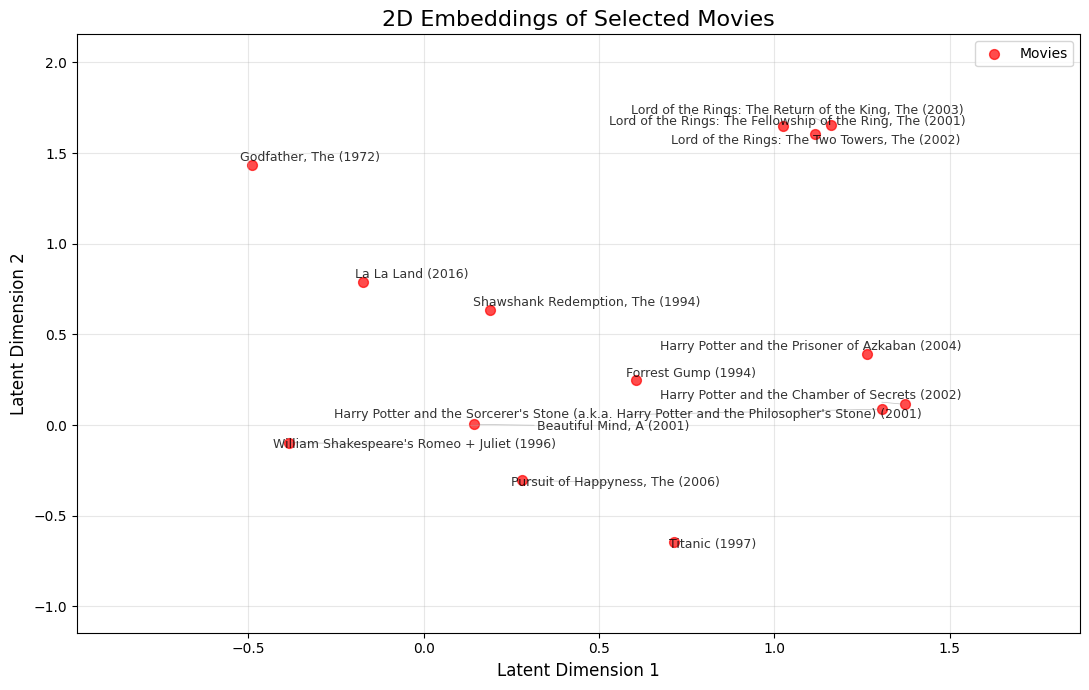

In [9]:

# Example movie titles for Lord of the Rings, Harry Potter series, romantic movies, and dramas
specific_titles = [
    # Lord of the Rings series
    "Lord of the Rings: The Fellowship of the Ring, The (2001)",
    "Lord of the Rings: The Two Towers, The (2002)",
    "Lord of the Rings: The Return of the King, The (2003)",
    # Harry Potter series
    "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
    "Harry Potter and the Chamber of Secrets (2002)",
    "Harry Potter and the Prisoner of Azkaban (2004)",
    # Romantic movies
    "Titanic (1997)",
    "	Pride and Prejudice (2003)",
    "	Notebook, The (2004)",
    "William Shakespeare's Romeo + Juliet (1996)",
    "La La Land (2016)",
    # Drama movies
    "Shawshank Redemption, The (1994)",
    "Forrest Gump (1994)",
    "Godfather, The (1972)",
    "Beautiful Mind, A (2001)",
    "Pursuit of Happyness, The (2006)"
]

# Filter the DataFrame for specific movies
movies_data= pd.read_csv('/content/drive/MyDrive/ml-25m/movies.csv')
movies_df = pd.DataFrame({
    "movieId": id_to_movie,
    "movie_idx": range(len(id_to_movie))  # Map movie IDs to internal indices
})
movies_with_titles = pd.merge(movies_df, movies_data, on="movieId", how="inner")
specific_movies = movies_with_titles[movies_with_titles["title"].isin(specific_titles)]





if specific_movies.empty:
    print("No matches found for the specified movie titles.")
else:
    # Extract 2D vectors and titles for the specific movies
    movie_vectors_subset = movie_vectors[specific_movies["movie_idx"].values]
    titles = specific_movies["title"].values

    # Create the plot
    plt.figure(figsize=(11, 7))
    plt.scatter(movie_vectors_subset[:, 0], movie_vectors_subset[:, 1], alpha=0.7, c='red', s=50, label="Movies")

    # Annotate with titles
    texts = []
    for i, title in enumerate(titles):
        texts.append(plt.text(
            movie_vectors_subset[i, 0], movie_vectors_subset[i, 1], title, fontsize=9, alpha=0.8
        ))


    adjust_text(
        texts, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5)
    )

    # Adjust axis limits dynamically
    plt.xlim(movie_vectors_subset[:, 0].min() - 0.5, movie_vectors_subset[:, 0].max() + 0.5)
    plt.ylim(movie_vectors_subset[:, 1].min() - 0.5, movie_vectors_subset[:, 1].max() + 0.5)


    plt.title("2D Embeddings of Selected Movies", fontsize=16)
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('2D_embeddings_with_titles.pdf',format='pdf', bbox_inches='tight')

    plt.show()




Least and most Polarized movies after training on the full 25M dataset

In [13]:
movie_vectors = pd.read_csv('/content/drive/MyDrive/25M_Movie_Vectors.csv', index_col='Movie_ID').values
# Compute the magnitude of each movie vector
movie_magnitudes = np.linalg.norm(movie_vectors, axis=1)

movies_data= pd.read_csv('/content/drive/MyDrive/ml-25m/movies.csv')
movies_df = pd.DataFrame({
    "movieId": id_to_movie,
    "movie_idx": range(len(id_to_movie))
})
movies_with_titles = pd.merge(movies_df, movies_data, on="movieId", how="inner")
# Add magnitudes to the DataFrame
movies_with_titles["magnitude"] = movie_magnitudes

# Sort by magnitude to find most and least polarizing movies
most_polarizing = movies_with_titles.sort_values(by="magnitude", ascending=False).head(10)
least_polarizing = movies_with_titles.sort_values(by="magnitude", ascending=True).head(10)

# Compute rating variance
movies_with_titles["rating_variance"] = movies_with_titles["movie_idx"].apply(
    lambda idx: np.var([rating for _, rating in ratings_by_movies[idx]])
)

# Display results
print("Most Polarizing Movies (Highest Magnitudes):")
print(most_polarizing[["title", "magnitude"]])

print("\nLeast Polarizing Movies (Lowest Magnitudes):")
print(least_polarizing[["title", "magnitude"]])


Most Polarizing Movies (Highest Magnitudes):
                                                  title  magnitude
2589                 Twilight Saga: Eclipse, The (2010)   5.433015
3312                                    Twilight (2008)   5.375892
3318                Twilight Saga: New Moon, The (2009)   5.277247
3328  Twilight Saga: Breaking Dawn - Part 2, The (2012)   5.272905
3327  Twilight Saga: Breaking Dawn - Part 1, The (2011)   5.236128
939              Dumb & Dumber (Dumb and Dumber) (1994)   5.081844
387   Star Wars: Episode II - Attack of the Clones (...   4.979396
293    Star Wars: Episode I - The Phantom Menace (1999)   4.736407
243   Star Wars: Episode III - Revenge of the Sith (...   4.652989
1752                                         Saw (2004)   4.553451

Least Polarizing Movies (Lowest Magnitudes):
                                                   title  magnitude
56501                                   Yesterday (2002)   0.000007
56500                  Shaolin Fight